## One last thing: Twitter geography

I don't know how much of this we're going to be able to cover, so it's going to be a little sparse.  One of my major interests in Twitter corpora is the geographic aspect of tweets. Tweets *can* contain geographic information, though many don't.  This information can come from multiple sources: the tweet itself can be **geotagged**, with a latitude-longitude pair or city name, or the user can have a self-specified **location** (which is much noisier and may be a stright-up lie).  Around 3% of tweets have geotags, and in my experience, somewhere around 30-60% have usable geographic information in the user's location (this depends on what granularity of geographic information you're willing to accept).

In [1]:
#The usual initialization stuff

import sys, os, re
from pprint import pprint                           #Important for reading through JSONs
from time import localtime,strftime,sleep,time      #Important for dealing with Twitter rate limits
import datetime                       #Important for processing Twitter timestamps
import twitter

sys.path.append(os.path.abspath("lib"))
from seetweetlib225 import *

cons_oauth_file = 'c.xxx'
if os.path.exists(cons_oauth_file):
    constoken, conssecret = twitter.read_token_file(cons_oauth_file)
else:
    constoken = raw_input("What is your app's 'Consumer Key'?").strip()
    conssecret = raw_input("What is your app's 'Consumer Secret'?").strip()
    wf = open(cons_oauth_file,'w'); wf.write(constoken+'\n'+conssecret); wf.close()
    
app_oauth_file = 'a.xxx'
if not os.path.exists(app_oauth_file):									#if user not authorized already
	twitter.oauth_dance("your app",constoken,conssecret,app_oauth_file)		#perform OAuth Dance
apptoken, appsecret = twitter.read_token_file(app_oauth_file)					#import user credentials

tsearch = twitter.Twitter(auth=twitter.OAuth(apptoken,appsecret,constoken,conssecret))	#create search command\

#Copying the code to make URL
def extracttweetURL(j):
	return 'http://twitter.com/'+j['user']['screen_name']+'/status/'+str(j['id'])


In [4]:
#Global variables
loclist = ["30.8,-98.6","39.8,-95.6","32.8,-117.6","37.8,-122.6"]
radius = "2500km"
multiloc = True
tweetspersearch = 75
maxpages = 20
maxid = float("+inf")
importcsv = ''
overwrite = 'w'
outfile = ''
keeptweets = True
startat = 0
header = True
throttle = True
checklimits = 3 		#To avoid overquerying the rate_limit function, only check every N iterations
importmultiloc = False
newmultiloc = False
onlyincltweets = True
wff = False
trackfails = False
MAXERRORS = 3
scheduled = False
raw = True
tweetcount = 0

In [5]:
#tsearch = authorize()

## Main geographic code

This is the full code I use for searching throughout the U.S.; it's a lot more complicated than the stuff from the previous files, because it implements throttling, multiple search locations, and error catching that the previous ones didn't.  It also outputs the tweet information into a comma-separated value file for safekeeping.

I won't be going into the details of this code, but hopefully it's clear enough that you'll be able to figure out nay parts of it that you need.

We'll do a couple simple test cases below.  Note that in general, you need to perform baselining for geographic analyses.  This code can handle baselining, and a discussion of geographic baselines is available in Doyle 2014.

### Test case: where's the interstate?

To start, let's do a really simple search, and one that has a well-known geographic distribution.  Specifically, let's look for tweets mentioning interstates.

I-85 is an interstate in the Southeastern U.S., running from Alabama to Virginia.  [Wikipedia](https://en.wikipedia.org/wiki/Interstate_85) has a nice little map of the route.  Let's see if we can re-create that map real quick.

Start by specifying a search term; here we'll go with "I-85" (in quotes so we don't get distractor tweets like "I ate 85 cakes").

In [111]:
#fixterm() converts from human-readable to "URL-encoded" 
def fixterm(term1):
    term1 = re.sub(' ','+',term1)
    term = re.sub('\"','%22',term1)
    return(term)

term = fixterm('"I-85"')
print "Searching for", term

Searching for %22I-85%22


Now here's the bulk of the code. I'll return to this over and over again to actually perform the searches.
<a id="code"></a>

In [123]:
#Basic startup processing
if (importcsv and multiloc):
	importmultiloc = True
elif multiloc:
	newmultiloc = True


if importcsv:
	rf = open(importcsv,'r')
	firstline=True
	tidnum = 0
	tids = []
	centers = []
	incls = []
	for line in rf:
		if line[0] == '#':
			continue
		splitline = line.strip().split(',')
		if firstline:
			tidnum = splitline.index('tid')
			if importmultiloc:
				centernum = splitline.index('center')
				inclnum = splitline.index('incl')
			firstline=False
		else:
			if onlyincltweets:							#If we're excluding excluded tweets from baseline calc, skip to next line if incl=0
				if int(splitline[inclnum])==0:
					continue
			tids.append(long(splitline[tidnum])-1)
			if importmultiloc:
				centers.append(int(splitline[centernum]))
				incls.append(int(splitline[inclnum]))
	tids = tids[startat:]
	if importmultiloc:
		centers = centers[startat:]
		incls = incls[startat:]
	maxpages = len(tids)
	tids.append(0)
	firsthit = tids[0]
	rf.close()
else:
	firsthit = float("+inf")

outcomes = {}
locnum = -1
if newmultiloc:
	tweetlist = [0]*len(loclist)
	searchesleft = [0]*len(loclist)
	mintids = [0]*len(loclist)
	maxtids = [0]*len(loclist)
elif importmultiloc:
	tweetlist = [0]*maxpages		#tweetlist[tweetnum][locnum][resnum] = [outline,loc,tid] for the resnum-th baseline tweet in loc locnum on testtweet tweetnum
	mintids = [0]*maxpages
	maxtids = [0]*maxpages
	

In [124]:
#Actual search-performing code
outfile = ''

if importcsv:
	if not outfile:
		outfile = 'base.'+term.strip('%22')+'.'+importcsv
else:
	#if scheduled:
	#	scheddir = 'scheduled'
	#	if not os.path.exists(scheddir):
	#		os.mkdir(scheddir)
	#	outfile = scheddir+'/'+term1.strip('\"')+'.'+strftime('%Y%m%d.%H%M')+'.csv'
	if not outfile:
		outfile = term.strip('%22')+'.csv'
wf = open(outfile,overwrite)
latlong = loclist[0]
#TODO: block out the header stuff
if header:
	wf.write('#Compiled by SeeTweet '+versionnum+'.\n')
	wf.write('#Search performed at '+strftime('%Y-%m-%d %H:%M')+'\n')
	if not multiloc:
		wf.write('#Search location: '+latlong+','+radius+'\n')
	else:
		wf.write('#Search location: U.S. 4-location coverage points (Texas, KC, SD, SF)\n')
	wf.write('#Search term: '+term1+'\n')
if (overwrite=='w' and not multiloc):
	wf.write('day,year,month,date,hour,minute,second,source,city,state,lat,long,uid,tid\n')
elif (overwrite=='w' and newmultiloc):
	wf.write('day,year,month,date,hour,minute,second,source,city,state,lat,long,uid,tid,center,incl\n')
elif (overwrite=='w' and importmultiloc):
	wf.write('day,year,month,date,hour,minute,second,source,city,state,lat,long,uid,tid,origtid,origincl,center,incl\n')
if keeptweets:
	tweetdir = 'tweetarchive'
	if not os.path.exists(tweetdir):
		os.mkdir(tweetdir)
	#if not os.path.exists(tweetdir+'/'+scheddir):
	#	os.mkdir(tweetdir+'/'+scheddir)
	outtweetfile = tweetdir+'/'+os.path.splitext(outfile)[0]+'.tweets'
	wft = open(outtweetfile,overwrite)
	if overwrite=='w':
		if raw:
			wft.write('day\tyear\tmonth\tdate\thour\tminute\tsecond\tloc\tuid\ttid\ttweet\ttlength\trt\n')
		else:
			wft.write('loc,uid,tid,tweet\n')
if trackfails:
	faildir = 'failures'
	if not os.path.exists(faildir):
		os.mkdir(faildir)
	outfailfile = faildir+'/'+os.path.splitext(outfile)[0]+'.fails'
	wff = open(outfailfile,'w')
	
	
	#Note: block out the rate check
for latlong in loclist:
	locnum = locnum + 1
	geocodestr = latlong+","+radius
	print "\nSearch centered at:", latlong, "(locnum "+str(locnum)+")"
	if newmultiloc:
		currloctweets = []
		tidbycurrloc = []
	
	for pagenum in range(0,maxpages):
		print ''
		if importmultiloc:
			if (locnum==0):
				tweetlist[pagenum] = []
				maxtids[pagenum] = []
				mintids[pagenum] = []
			#print maxtids
			currloctweets = []
			tidbycurrloc = []
		#Examining the rate limit
		if (pagenum % checklimits == 0):
			r = getlimits(tsearch)
			if r['remaining'] <= checklimits:
				print "\n\n**Paused because of rate limit.**"
				print "Current time:",strftime('%I:%M:%S')
				print "Reset time:  ",strftime('%I:%M:%S',localtime(r['reset']))
				if not multiloc:
					print "Resume with flag -s="+str(startat+pagenum)
				else:
					print "Stopped on location "+str(locnum)+", tweet "+str(startat+pagenum)+"/"+str(maxpages)
				print "--"
				print tweetcount, 'tweets found. Centered at', geocodestr
				print outcomes
				if throttle:
					waittime = r['reset']-time()+30
					print "Waiting", round(waittime), "seconds before resuming."
					sleep(waittime)
				else:
					sys.exit()
			elif r['remaining'] < 11:
				print "\n\n**WARNING:", r['remaining'], "queries remaining.**"
				print "Current time:",strftime('%I:%M:%S')
				print "Reset time:  ",strftime('%I:%M:%S',localtime(r['reset']))
				print ""
				print "\n\n"
				sleep(10)
		
		#Adding a catch for various Twitter errors
		errors = 0
		while (errors < MAXERRORS):
			try:
				if (firsthit == float("+inf")):
					res = tsearch.search.tweets(q=term+'+-rt',geocode=geocodestr,count=str(tweetspersearch),result_type="recent")
					#pprint(res['statuses'][99])
				else:
					#print 'Test:', term+'+-rt',geocodestr,str(tweetspersearch),str(firsthit)
					res = tsearch.search.tweets(q=term+'+-rt',geocode=geocodestr,count=str(tweetspersearch),result_type="recent",max_id=str(firsthit))
					#pprint(res['statuses'][99])
				break
			except TwitterHTTPError as e:
				errors = errors + 1
				print "Twitter Error encountered. Retrying",MAXERRORS-errors,"more times."                                                       
				print "\n"+e.response_data
				sleep(5)
		if (errors==MAXERRORS):
			print "Repeated errors encountered, possibly due to rate limit."
			print "Will wait 15 minutes and try once more before quitting."
			sleep(900)
			try:
				if (firsthit == float("+inf")):
					res = tsearch.search.tweets(q=term+'+-rt',geocode=geocodestr,count=str(tweetspersearch),result_type="recent")
				else:
					res = tsearch.search.tweets(q=term+'+-rt',geocode=geocodestr,count=str(tweetspersearch),result_type="recent",max_id=str(firsthit))
			except:			
				raise Exception("Gave up because of repeated errors, sorry.")
		res = res['statuses']
			
		print len(res), 'hits on page', startat+pagenum+1, '(max_id='+str(firsthit)+')'
		print r['remaining']-1, 'queries remaining.'
		if (len(res)==0):
			print 'Out of tweets at this location.'
			#print 'Test:', term+'+-rt',geocodestr,str(tweetspersearch),str(firsthit)
			#sleep(1)
			#res = tsearch.search.tweets(q=term+'+-rt',geocode=geocodestr,count=str(tweetspersearch),result_type="recent",max_id=str(firsthit))
			#pprint(res['statuses'][99])
			break
		for i in range(0,len(res)):
			tweetcount = tweetcount + 1
			[outline,outcome,tid,tline] = extractinfo(res[i],wff,raw)
			if outline:
				if not multiloc:
					wf.write(outline)
				elif newmultiloc:
					currloctweets.append([outline[:-1]+','+str(locnum)+'\n',locnum,long(tid)])
					tidbycurrloc.append(float(tid))
					#wf.write(outline[:-1]+','+str(locnum)+'\n')
				elif importmultiloc:
					currloctweets.append([outline[:-1]+','+str(tids[pagenum]+1)+','+str(incls[pagenum])+','+str(locnum)+'\n',locnum,long(tid)])
					tidbycurrloc.append(float(tid))
			if keeptweets:
				#wft.write(tline.encode('ascii','ignore'))
				if not raw:
					wft.write(tline.encode('ascii','ignore'))
				if raw:
					wft.write(tline.encode('ascii','replace'))		#maybe create a separate .utweets file with the Unicode versions of tweets
			outcomes[outcome] = outcomes.get(outcome,0)+1
			if importcsv:
				firsthit = tids[pagenum+1]
			else:
				if firsthit > long(tid):			#if current tweet came before previous oldest, update oldest
					firsthit = long(tid)-1
		if importmultiloc:
			if len(tidbycurrloc) > 0:
				maxtids[pagenum].append(max(tidbycurrloc))
				mintids[pagenum].append(min(tidbycurrloc))
			else:
				maxtids[pagenum].append(0)
				mintids[pagenum].append(0)				
			tweetlist[pagenum].append(currloctweets)
	#endfor searches within a location
	if newmultiloc:
		if len(tidbycurrloc) > 0:
			maxtids[locnum] = max(tidbycurrloc)
			mintids[locnum] = min(tidbycurrloc)
		else:
			maxtids[locnum] = 0
			mintids[locnum] = 0
		searchesleft[locnum] = maxpages-pagenum-1			#calculating how many pages were left in the most maxed-out search
		tweetlist[locnum] = currloctweets
	overwrite = 'a+'
	header = False
	if importcsv:
		firsthit = tids[0]
	else:
		firsthit = float("+inf")

#Endfor multiple locations
if newmultiloc:
	balanceandprint(tweetlist,mintids,maxtids,searchesleft,wf)
elif importmultiloc:
	for pagenum in range(0,maxpages):
		balanceandprint(tweetlist[pagenum],mintids[pagenum],maxtids[pagenum],[0]*len(loclist),wf)
wf.close()
if keeptweets:
	wft.close()
if trackfails:
	wff.close()
	


Search centered at: 30.8,-98.6 (locnum 0)

75 hits on page 1 (max_id=inf)
101 queries remaining.
F:  2497719225
CS: dearborn,mi *10:30pm*  Her: "Hey wyd lets chill"  Him: "Oh sorry, I can't I have to cut the grass it's getting long" https://t.co/YOBSJUYFSx
CS: chicago,il Cut the Grass n the 🐍 will show. Thank the swoosh for that tho.
CS: baton rouge,la @JustinHill I wish they would cut the grass lower or something to help a brother out.
CS: houston,tx Hopefully it don't rain tomorrow so I can cut the grass 🙄
CS: toledo,oh You have to cut the grass low so the snakes can show.
KC: san antonio @henryjd23 @T_jordan1 We can't even get him to cut the grass with a lawn mower so I don't think so lol
F: ontario  canada 748395763
F: university of delaware 305391349
F: nm 797336382
F: mich 767064728
CS: bessemer,al KATIE I CUT THE GRASS TOO OMG thomas and I fight over whose gonna do it. #weareawesome https://t.co/hFKrn7sdUD
F: ashland 26983811
F: northwest 190547844
CS: amarillo,tx Don't cut the

CS: kenosha,wi How can you cut the grass and tweet & the same damn time https://t.co/krLY0Cecde
CS: chesapeake,va Ok Cut The Grass Weed Eatered The Yard, Picked Beans & Squash From The Garden Cleaned Cut And snapped Then Froze,... https://t.co/MRt1lnwrxW

75 hits on page 3 (max_id=879087725240082431)
101 queries remaining.
F: i am wherever you say i am 976188361
F: w/ robert 942298296
F: pennsylvania  usa 870000039229349889
CS: westborough,ma @columbusmonthly @patrickmadrid Once he tried to grow palm trees on on his Delaware OH property and had goats to "cut the grass"
F: jamison 920316212
F: georgia  usa 47355610
KC: chicago I cut the grass to see the snakes, but I still treat em all the same. 🐍
F: indy 19320405
CS: columbia heights,mn Trying to get motivated to cut the grass !! https://t.co/EPaxU5950G
F: tennessee  usa 1906238503
F: maryland 20375064
KC: st louis Im about to cut the grass in my backyard......this is BS @Jokeeee_ @StDxDrag
CS: pittsburgh,pa I just cut the grass  my pa

CS: charlotte,nc My dad dropped off the lawn mower like I'm able bodied enough to cut the grass https://t.co/0YR4hPJopZ
F: kentucky  usa 765214735570698240
F:  1005155280
CS: atlanta,ga I'm about to cut the grass like this..... SOOOOO HOTTTTT #gawx https://t.co/TI1JH6L3iK
CS: richmond,tx Having a big backyard is cool and all, until you have to cut the grass in 90 degrees Houston weather
CS: lexington,ky Should probably cut the grass before the Cindy-induced deluge arrives
KC: philadelphia My dad is buying shoes and picks these up and says "the only problem is when I cut the grass" like this man is buyi… https://t.co/gY9DrDpr8B
F: granada hills  los angeles 982927124
F: norge 2810632702
F: hell.. 1644470725
KC: norfolk These niggas cut the grass every week, cut that shit off
CS: san antonio,tx someone give me a side job for my days off. ill clean, cut the grass, whatever. 😢
F: essex 27004865
CS: san antonio,tx I have the hardest playlist for when I have to cut the grass
F: kansas 870292

F: texas and tennessee 869983448102039552
CS: norfolk,va Helped Tubby cut the grass
F: here. 2760435478
F: st clair shores  mi 4700451878
F: paradise island 102778355
F: toronto  on 420715533
CS: lafayette,la Y'all cut the grass today. #TropicalStorm
CS: woods cross,ut A fluffy dog helps his owner do some landscaping by hopping on this riding mower to cut the grass! https://t.co/l3xzHv8QB9
F: ontario  canada 88593761
CS: oklahoma city,ok @AllyWarrennn I was thinking I need to cut the grass when I get home tonight.
F: the university of mississippi 505308993
CS: beverly hills,fl Today is obviously not a trading day on the Market... time to cut the grass.
F: united states 802308172719460352
CS: orlando,fl Guess I'll cut the grass & mind my business.
CS: lafayette,la Y'all it's 9 am 👟 I ran 2.5 miles + cut the grass (prepping for this tropical storm) = 10,000 steps already! •... https://t.co/kvNh8an99d
F: united states 1597341458
CS: san antonio,tx Time to cut the grass😅👨🏻‍🌾
F:  478155077


F: mckendree university 799357304
F: the bay 18591506
F: southwest florida 957973243
F: nevada usa 269913669
CS: naples,fl Cut the grass before the rain 🤘🏼
CS: greensboro,nc Living in a house is so much more work !!! Finding someone to cut the grass, remembering trash day. Etc
CS: oak forest,il i'm too high to cut the grass
CS: cleveland,oh Cut the grass and going for a run before work....who is this guy? #hustle #dailygrind
F: maryland  usa born and raised 34308524
F: america 4497982633
CS: meridian,ms well off to cut the grass
F: ontario  canada 752661745810939904
F: ontario  canada 752661745810939904
F:  2741132973
F: crossett 29815685
F: indiana  usa 119542963
CS: new orleans,la Why do lawn care companies in New Orleans, cut the grass but don't trim the trees also ?Trim them ,before they grow out into the streets.🤔
CS: chicago,il 🏦🏭🏧OK so then we have to go to Walmart. When we come back this afternoon after you cut the grass I'll do the edging🏭
F:  2880176074
CS: hiram,ga I cut the

CS: miami,fl i cut the grass n saw all the snakes
CS: pittsburgh,pa Not much worse than having to go to the gas station so you can cut the grass
KC: louisville Working in the garden today. Need to cut the grass and harvest some lettuce and kale.
CS: fort lauderdale,fl @realDonaldTrump @foxandfriends I'd rather play golf, go to church, have brunch, play with the kids, go to the mark… https://t.co/f1kb9Pmyc6
F: ⭕️〽️call me hugh hefner❗️❗️ 2449821513
CS: white plains,ny Of course my dad wants to cut the grass while I'm laying out on the hammock
F: joliet 1080626191
CS: waltham,ma @JacquiHeinrich You're welcome! Off to cut the grass! Enjoy the newscast!
CS: castle hills,tx @RJSzczerba @realDonaldTrump He Rob, go cut the grass,  let the man do his job
CS: atlanta,ga @Rossmac212 Me when the wife says cut the grass.
CS: lakemore,oh A nice day to cut grass https://t.co/WUVLZbd52j via @weebly
F: east windsor nj 2453435701
F: in michigan 133981546
CS: mercedes,tx @PapaRay14 @mdrizzle_3 @michelle

CS: federal way,wa @caroabooth Sounds kinda boring...I mean you have to buy food,cut the grass,feed the kids...you'd need to get out once in a while...
CS: buffalo,ny @marisamarinelli no like for real... i would like to know how this mans has 7 hours in his day to cut the grass 🤔
F: virginia  usa 816554551012630528
CS: louisville,ky Listen to Cut The Grass by MB Cobi #np on #SoundCloud https://t.co/kup4bQrm6q
F: great perhaps 4098962375

75 hits on page 5 (max_id=878068013290766336)
89 queries remaining.
F: winnipeg  manitoba 758403946318663680
CS: cleveland,oh I've officially decided the best beer ever is ... after you've cut the grass.
CS: kingsville,tx 2 hours to cut the grass....sad thing it it wasn't even high 🙄
F: toronto  on 234411833
CS: san antonio,tx "Cut the grass" shoes https://t.co/9lgFlALKB3
F: wisconsin  usa 842569642061250560
CS: racine,wi Mad asf I just cut the grass (two big ass yards) because I thought my brother wasn't home. But no. This nigga in his room playing 2k

CS: chicago,il This man was using scissors to cut the grass........ is that a thing lol
CS: louisville,ky The @FernCreekHigh garden will love this rain! 😍Guess I need to cut the grass at home ASAP ⛈ @MrHallFernCreek https://t.co/ixWK1HV8aQ
CS: raleigh,nc Today I somehow managed to run 6 miles an cut the grass without dropping dead https://t.co/5CFn6NKfR8
F: the moon 1628149813
F: somewhere 777445133730082816
CS: jacksonville,ar My Dad just told me I got a OFFER 2 BYU !!!!!!!!!!! (Back Yard University) time to cut the grass!!!! LOL
CS: west lafayette,in @kaitlynkab Tell dad to cut the grass
CS: marietta,ga I need it to stop raining for just a couple days so I can finally cut the grass
CS: metuchen,nj Sure honey, I'll cut the grass.  See you Thursday! https://t.co/AYKrU0p8XT
CS: atlanta,ga @SuburbanMatron Guess I won't be able to cut the grass today then. Oh darn, what a shame 😆
CS: houston,tx I remember when I live in my mama house I use to cut the grass . Now I have my own house I cut 

0 hits on page 9 (max_id=876412697918799872)
86 queries remaining.
Out of tweets at this location.

Search centered at: 32.8,-117.6 (locnum 2)

75 hits on page 1 (max_id=inf)
83 queries remaining.
F:  2497719225
CS: baton rouge,la @JustinHill I wish they would cut the grass lower or something to help a brother out.
CS: houston,tx Hopefully it don't rain tomorrow so I can cut the grass 🙄
KC: san antonio @henryjd23 @T_jordan1 We can't even get him to cut the grass with a lawn mower so I don't think so lol
CS: seattle,wa @rezo_dj @Lead0ffMan And I'm about to workout and then cut the grass out back before it gets dark. 😫
F: nm 797336382
F: mich 767064728
CS: amarillo,tx Don't cut the grass you might kill @albertsilva25 🐍🐍🐍
F: united states 809200684453285891
CS: san diego,ca Thx for chatting, I gotta go cut the grass.  love you all⚓️
CS: houston,tx I have cut the grass every past weekend this month, STAY DOWN YOU FUCKERS
F: the trap 563312530
F:  804830711085600768
F: united states 4517191


30 hits on page 3 (max_id=877089591278399489)
83 queries remaining.
CS: lubbock,tx I cut the grass in the front and backyards. I did a pretty good job for my first time ☺️ proud of myself
CS: mission,tx Remember to cut the grass 🐍
F: canada 718048882433732608
F: orange county  ca 2165467837
F: runnin with the pitchfork kids 2259543830
CS: los angeles,ca @GodlessNZ @AStandUpGirl They cant even cut the grass on a regular basis
F: area-51 2297147899
F: united states of america 111714412
CS: scottsdale,az Cut the grass, kill the snakes.
F: winnipeg  mb 700302037
F: louisiana  usa 2355484646
F: goin somewhere 742909906966040577
CS: lawton,ok Soooo since my bf is gone for 2 weeks I took it upon myself to cut the grass. Oh hell no. 😭😭😭 I almost passed out 😵
CS: los angeles,ca Damn I gotta cut the grass
CS: los angeles,ca You should have waited until a tornado showed up before you cut the grass. You could become an internet sensation.… https://t.co/MSgAS4SrTl
F: napping probably 2858694120
CS

F: usa! usa! usa! 2661779676
CS: houston,tx When you cut the grass the snakes will show I kno i kno I know
F: south la 2287832730
F:  877303014008045568
CS: seattle,wa @seattledot you're doing work on my block would you have cut the grass on the parking strip and put it in my garbage can today?
CS: san antonio,tx My parents on some other shit thinking Ima cut the grass at 9 o'clock at night 💀
CS: dittmer,mo When you have to cut the grass but know isis out there plotting #gunsofinstagram #pewpewlife… https://t.co/gP0GIsw55D
F: vancouver  bc 15984719
CS: wichita,ks @Tre57magnum @jayintha 🤣🤣 cut the grass bruh!
CS: denver,co @RicepirateMick I have been living in apartments my whole life. My favorite part is the fact that i don't have to cut the grass
CS: roma,tx Cut the grass feel good
F: united states 240096206
F: missouri  usa 24120384
F: canada&usa 127623510
CS: san antonio,tx My apartment complex hasn't cut the grass in about 3 months....... my dog disappears in it. Its a mosquito inf

### Mapping I-85

We've now got a bunch of tweets mentioning I-85.  To see if the results are making any sense, let's plot the tweets on an outline of the U.S.  We'll jitter the tweets because a lot of these tweets will be coming from the same couple of cities.

In [98]:
import numpy as np

#Jitter code, add 2D Gaussian noise with .25 degree (latitude/longitude) std deviation.
def jitter(x):
    return(x+np.random.randn(*np.shape(x))*.25)

In [99]:
#To get a basic outline of the U.S., import all named cities from the U.S. Geological Survey
#(Only including lat/long for each)
def importmap(mapfile='../data/NationalFile_20120204.txt.cities'):
    usf = open(mapfile,'r')
    uslist = []
    header = 0
    for line in usf:
        splitline = line.strip().split(',')
        uslist.append([float(splitline[2]),float(splitline[3])])
    usf.close()
    usarr = np.array(uslist)
    return(usarr)

usarr = importmap()

In [139]:
#Re-import the saved tweet lists; again only lat/long
def importtweets(tweetfile):
    tf = open(tweetfile,'r')
    tlist = []
    header = 0
    for line in tf:
        if header<5:               #skipping the header
            header += 1
            continue
        splitline = line.strip().split(',')   #splitting up each line of the CSV
        if splitline[10]!='NA':               #If latitude is defined
            if (float(splitline[10])<50 and float(splitline[11])>-130):  #Omitting Alaska/Hawaii due to limited data
                tlist.append([float(splitline[10]),float(splitline[11])])
    tf.close()
    tarr = np.array(tlist)
    return(tarr)

iarr = importtweets('I-85.csv')

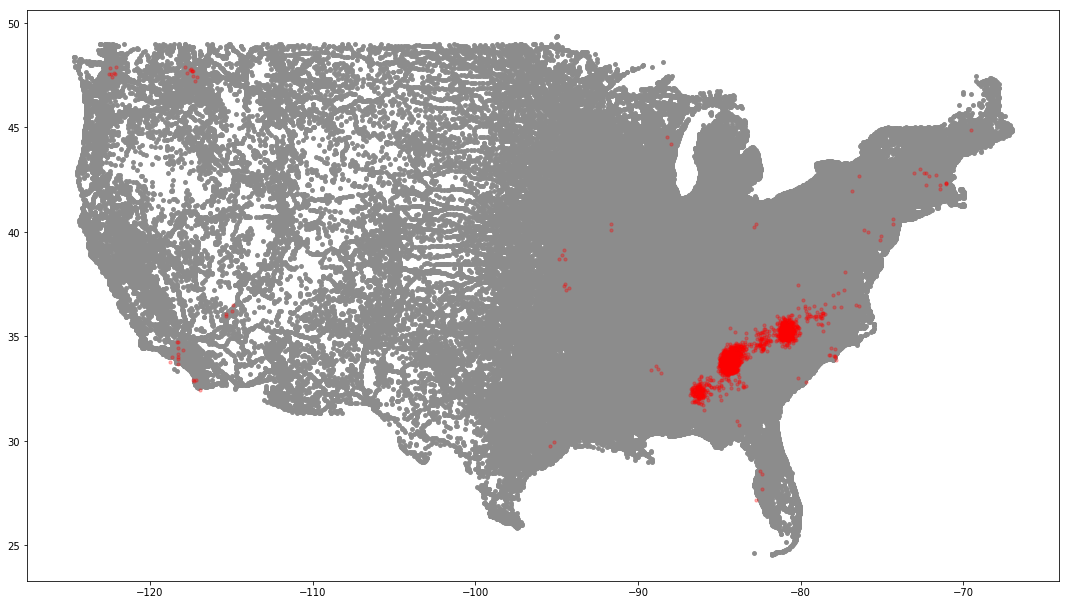

In [140]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots() 
ax.scatter(usarr[:,1], usarr[:,0], color='0.55', s=15, alpha=1)             #US Map locations
ax.scatter(jitter(iarr[:,1]), jitter(iarr[:,0]), color='r', s=10, alpha=.3) #Instances of 'I-85' tweets

fig.set_size_inches(18.5, 10.5)
plt.show()

## Let's talk about trucks

Okay, so speaking of interstates, let's talk about trucks.  You know those big trucks on the interstate?  What do you call them?  As it turns out, that can depend on where you're from.  Do you know where people call them *tractor-trailers*, *18-wheelers*, or *semi-trucks*?  As it turns out, Twitter does.

In [104]:
term = fixterm('18-wheeler OR eighteen-wheeler')

print "Searching for", term

Searching for 18-wheeler+OR+eighteen-wheeler


[up to code](#code)

In [ ]:
term = fixterm('semi truck')

print "Searching for", term

In [ ]:
term = fixterm('"tractor trailer"')

print "Searching for", term

In [128]:
ttarr = importtweets('tractor+trailer.csv')
starr = importtweets('semi+truck.csv')
ewarr = importtweets('18-wheeler+OR+eighteen-wheeler.csv')

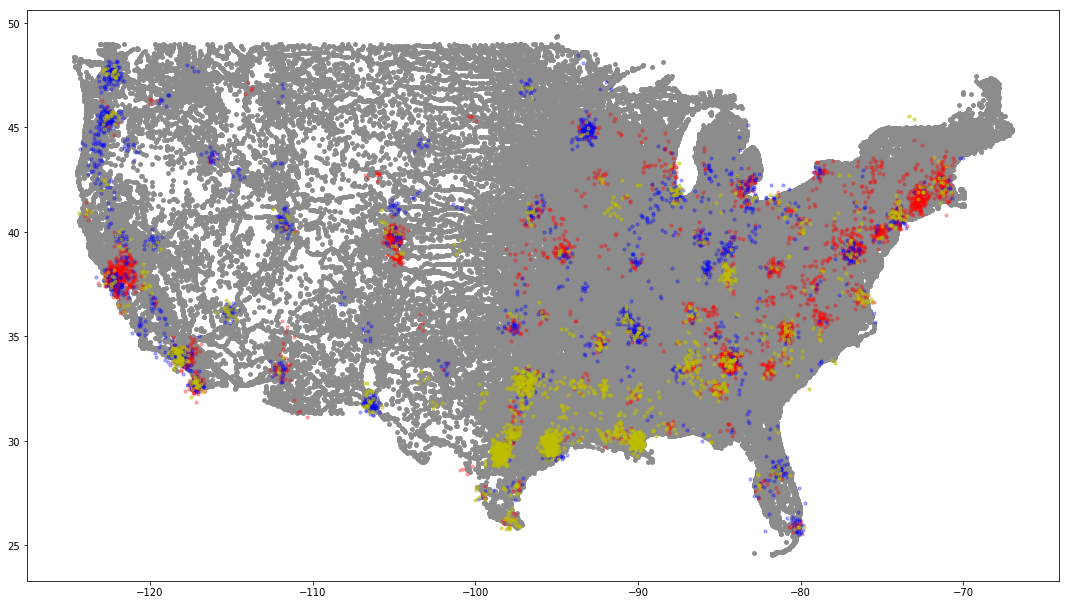

In [129]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(usarr[:,1], usarr[:,0], color='0.55', s=15, alpha=1)
ax.scatter(jitter(ttarr[:,1]), jitter(ttarr[:,0]), color='r', s=10, alpha=.3)
ax.scatter(jitter(starr[:,1]), jitter(starr[:,0]), color='b', s=10, alpha=.3)
ax.scatter(jitter(ewarr[:,1]), jitter(ewarr[:,0]), color='y', s=10, alpha=.5)

#plt.figure(figsize=(50,10))
fig.set_size_inches(18.5, 10.5)
plt.show()

#### Comparison to Josh Katz's data

Josh Katz has constructed a number of dialect maps for the U.S. based on replies to a variant of the Harvard Dialect Survey, with tens of thousands of respondents. We've managed to get a couple thousand references to trucks from the last week. Let's see if we're able to approximate his findings. [Katz 2017:128](http://web.stanford.edu/~gdoyle/temp/twitter/katz-trucks.jpg)

### You guys, or y'all?

Now how about second-person plurals?

In [144]:
term = fixterm('y\'all')

print "Searching for", term

Searching for y'all


[up to code](#code)

In [141]:
ygarr = importtweets('you+guys.csv')
yaarr = importtweets('y\'all.csv')

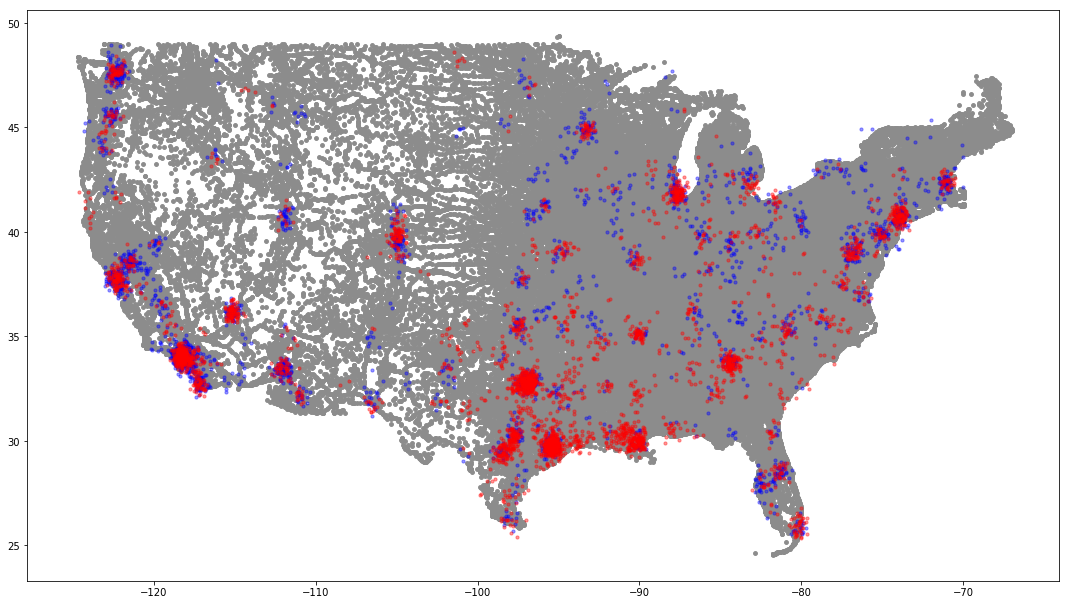

In [142]:
fig, ax = plt.subplots()
ax.scatter(usarr[:,1], usarr[:,0], color='0.55', s=15, alpha=1)
ax.scatter(jitter(ygarr[:,1]), jitter(ygarr[:,0]), color='b', s=10, alpha=.4)
ax.scatter(jitter(yaarr[:,1]), jitter(yaarr[:,0]), color='r', s=10, alpha=.4)

fig.set_size_inches(18.5, 10.5)
plt.show()

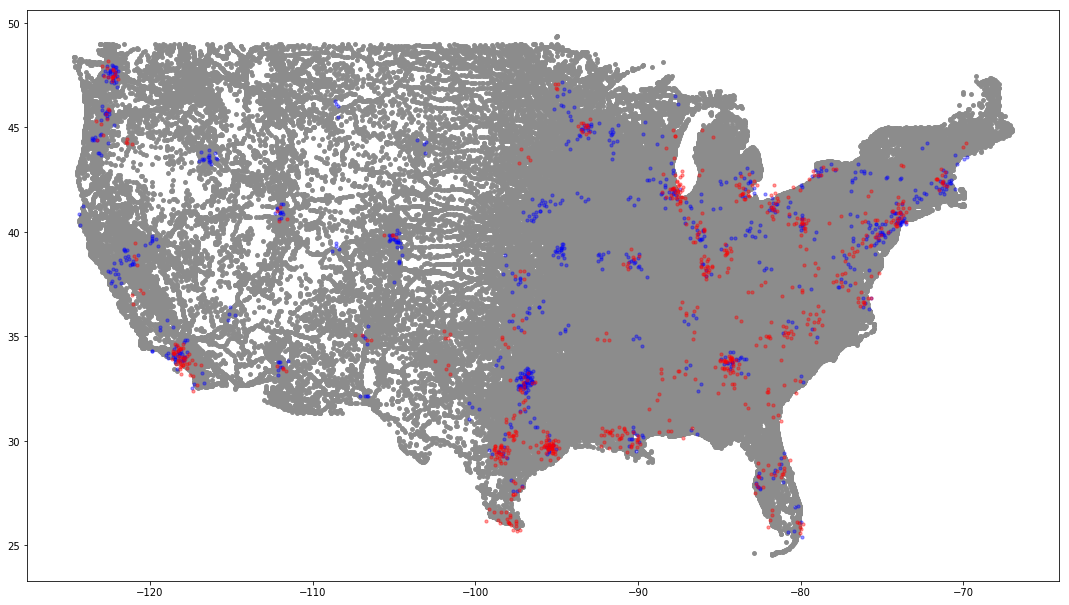

In [143]:
mlarr = importtweets('mow+the+lawn.csv')
cgarr = importtweets('cut+the+grass.csv')

fig, ax = plt.subplots()
ax.scatter(usarr[:,1], usarr[:,0], color='0.55', s=15, alpha=1)
ax.scatter(jitter(mlarr[:,1]), jitter(mlarr[:,0]), color='b', s=10, alpha=.4)
ax.scatter(jitter(cgarr[:,1]), jitter(cgarr[:,0]), color='r', s=10, alpha=.4)

fig.set_size_inches(18.5, 10.5)
plt.show()